In [1]:
# importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# importing data
df = pd.read_csv("02 - CVP.csv")
df.sample(10)

,country,date,Total Vaccinations,Daily Vaccinations,People Vaccinated 100,Daily Vaccination 1 mio,Vaccines
431,Czechia,2020-12-30,10439.0,3062.0,0.10,286.0,"Moderna, Pfizer/BioNTech"
483,Denmark,2021-01-13,132389.0,6120.0,2.29,1057.0,"Moderna, Pfizer/BioNTech"
1529,Russia,2020-12-17,0.0,3357.0,0.00,23.0,Sputnik V
829,Iceland,2021-01-24,0.0,1057.0,0.00,3097.0,"Moderna, Pfizer/BioNTech"
59,Austria,2021-01-24,139538.0,12013.0,1.50,1334.0,Pfizer/BioNTech
1121,Luxembourg,2021-01-12,2372.0,114.0,0.38,182.0,Pfizer/BioNTech
990,Italy,2021-01-21,1329920.0,45861.0,2.15,759.0,"Moderna, Pfizer/BioNTech"
1573,Saudi Arabia,2021-01-22,0.0,11302.0,0.00,325.0,Pfizer/BioNTech
1197,Mexico,2021-01-09,74794.0,5488.0,0.06,43.0,Pfizer/BioNTech
1423,Poland,2021-01-02,50391.0,9678.0,0.13,256.0,Pfizer/BioNTech


In [3]:
# checking data type
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2064 entries, 0 to 2063
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   country                  2064 non-null   object 
 1   date                     2064 non-null   object 
 2   Total Vaccinations       2064 non-null   float64
 3   Daily Vaccinations       2064 non-null   float64
 4   People Vaccinated 100    2064 non-null   float64
 5   Daily Vaccination 1 mio  2064 non-null   float64
 6   Vaccines                 2064 non-null   object 
dtypes: float64(4), object(3)
memory usage: 113.0+ KB


In [4]:
# date has not been in datetime format, we need to convert
df['date'] = pd.to_datetime(df['date'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2064 entries, 0 to 2063
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   country                  2064 non-null   object        
 1   date                     2064 non-null   datetime64[ns]
 2   Total Vaccinations       2064 non-null   float64       
 3   Daily Vaccinations       2064 non-null   float64       
 4   People Vaccinated 100    2064 non-null   float64       
 5   Daily Vaccination 1 mio  2064 non-null   float64       
 6   Vaccines                 2064 non-null   object        
dtypes: datetime64[ns](1), float64(4), object(2)
memory usage: 113.0+ KB


In [5]:
# to perform time series analysis (TSA), we need to get the whole month data
# some countries only have data for several days, so we plan to remove them from the dataset

# listing all countries
countries = df['country'].unique()

# counting the number of data in each country
num = []
for i in countries:
    a = len(df[df["country"]==i])
    num.append(a)

# creating dataframe that contain country and number of data
dataNum = pd.DataFrame(list(zip(countries, num)), columns = ["country", "total data"])
dataNum

# removing country with data less than 30 rows
sufCountry = dataNum[dataNum['total data']>=30]
print(f"There are {len(sufCountry)} countries that has sufficient data.")

# sort the data
sufCountry.sort_values(by=['total data', 'country'], ascending=[False, True]).head(10)

# Northern Ireland, Scotland, and Wales has the most data.
# We can use them to build  time series analysis model

There are 40 countries that has sufficient data.


,country,total data
48,Northern Ireland,51
57,Scotland,51
71,Wales,51
11,China,48
33,Israel,46
70,United States,45
19,England,44
69,United Kingdom,44
4,Bahrain,42
10,Chile,41


In [6]:
# creating new dataset for Northern Ireland
NIRL = df[df['country']=="Northern Ireland"]

#### **Notes**
We are going to use 'date' and 'Daily Vaccination' as our basis column to analyze the vaccination trend. The method will be Auto Regression Integrated Moving Average (ARIMA)

## Preparing North Ireland (NIRL) Dataset for ARIMA 

In [7]:
# setting date as index
NIRL.set_index('date', inplace=True)

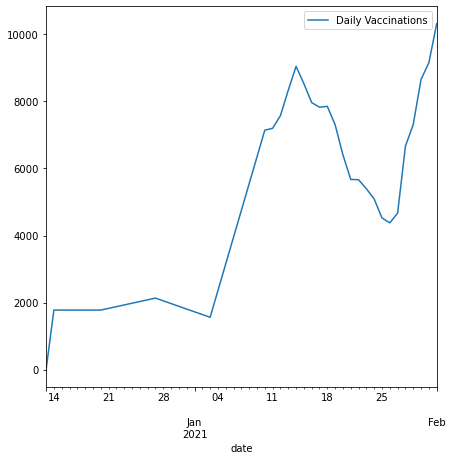

In [8]:
# graphing value of daily vaccination over time
NIRL = NIRL[['Daily Vaccinations']]
NIRL.plot(figsize=(7,7))
plt.show()

In [9]:
# checking stationarity
# stationarity means that the statistical properties of a a time series (or rather the process generating it) do not change over time

# creating user-defined function
from statsmodels.tsa.stattools import adfuller
def ad_test(dataset):
    dftest = adfuller(dataset, autolag='AIC')
    print("ADF : ", dftest[0])
    print("P-Value : ", dftest[1])
    print("# Lags : ", dftest[2])
    print("# Observation : ", dftest[3])
    print("Critical Value : ")
    for key, val in dftest[4].items():
        print("\t", key, "= ", val)
# source: https://www.youtube.com/watch?v=8FCDpFhd1zk&ab_channel=NachiketaHebbar

ad_test(NIRL['Daily Vaccinations'])
# P-Value is larger than critical value (means the data is not stationary)

ADF :  -0.9703564408607193
P-Value :  0.7639220128663247
# Lags :  7
# Observation :  43
Critical Value : 
	 1% =  -3.5925042342183704
	 5% =  -2.931549768951162
	 10% =  -2.60406594375338


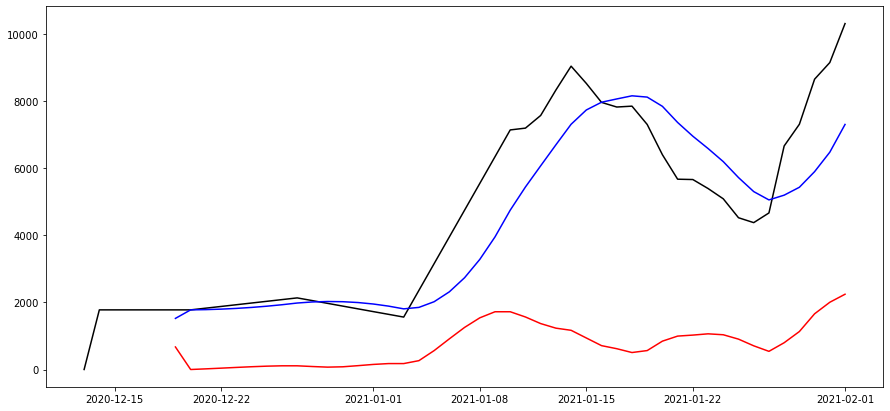

In [10]:
# calculating rolling mean and stdev
rollmean = NIRL.rolling(window=7).mean()
rollstd = NIRL.rolling(window=7).std()
# window is 7 to see the movement weekly

# plotting 'daily vaccination' value
plt.figure(figsize=(15,7))
plt.plot(NIRL['Daily Vaccinations'], color='black', label='original')
plt.plot(rollmean, color='blue', label='mean')
plt.plot(rollstd, color='red', label='stdev')
plt.show()

# rolling mean and stdev tend to increase over time

## Fitting using ARIMA

In [11]:
# importing libraries
from pmdarima import auto_arima
import warnings
warnings.filterwarnings('ignore')

In [12]:
# fitting the data
stepwiseFit = auto_arima(NIRL['Daily Vaccinations'], trace=True, suppress_warning=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=768.637, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=783.951, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=769.402, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=776.293, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=787.712, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=769.741, Time=0.14 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=767.919, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=770.391, Time=0.04 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=770.105, Time=0.07 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=769.373, Time=0.12 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=771.441, Time=0.08 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=768.008, Time=0.05 sec

Best model:  ARIMA(2,1,1)(0,0,0)[0] intercept
Total fit time: 1.176 seconds


In [13]:
# displaying fitting process summary
stepwiseFit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   51
Model:               SARIMAX(2, 1, 1)   Log Likelihood                -378.960
Date:                Mon, 01 Mar 2021   AIC                            767.919
Time:                        23:10:48   BIC                            777.479
Sample:                             0   HQIC                           771.560
                                 - 51                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    177.3826    166.626      1.065      0.287    -149.198     503.963
ar.L1         -0.2883      0.176     -1.643      0.100      -0.632       0.056
ar.L2          0.6573      0.122      5.370      0.000       0.417       0.897
ma.L1          0.8181      0.268      3.057      0.002       0.294       1.343
sigma2      2.168e+05   4.14e+04      5.242      0.000    1.36e+05    2.98e+05
===================================================================================
Ljung-Box (Q):                       33.25   Jarque-Bera (JB):                18.85
Prob(Q):                              0.77   Prob(JB):                         0.00
Heteroskedasticity (H):               1.61   Skew:                             0.88
Prob(H) (two-sided):                  0.34   Kurtosis:                         5.43
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## Training and Testing Data

In [14]:
# import library
from statsmodels.tsa.arima_model import ARIMA, ARIMAResults

In [15]:
# splitting the data into train set and test set
train = NIRL.iloc[:-10]
test = NIRL.iloc[-10:]

In [16]:
# train set fitting
model = ARIMA(train['Daily Vaccinations'], order=(1,1,0))
model = model.fit()

In [17]:
# prediction making
start = len(train)
end = len(train)+len(test)-1
pred = model.predict(start=start, end=end, typ='levels')

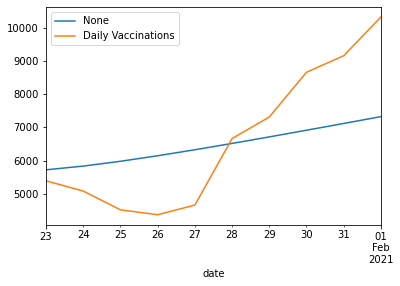

In [18]:
# compare prediction to test set
pred.plot(legend='Prediction')
test['Daily Vaccinations'].plot(legend='Orig')
plt.show()

In [19]:
# error analysis

#import libraries
from sklearn.metrics import mean_squared_error, r2_score
from math import sqrt

# calculating MSE and RMSE
print('MSE = ', mean_squared_error(pred, test['Daily Vaccinations']))
print('RMSE = ', sqrt(mean_squared_error(pred, test['Daily Vaccinations'])))
print('R2 Score = ', r2_score(pred, test['Daily Vaccinations']))

MSE =  2517533.3991216077
RMSE =  1586.673690183841
R2 Score =  -8.257119729882278


In [20]:
# saving model
model = ARIMA(train['Daily Vaccinations'], order=(1,1,0))
model_fit = model.fit()
model_fit.save('arima.pkl')

## Preparing Dataset for Universal Machine Learning

In [21]:
# selecting columns
df = df[['country', 'date', 'Daily Vaccinations']]

In [22]:
# import country population data
countryPop = pd.read_csv('02 - Country.csv')

# rename column
countryPop.rename(columns={"Country (or dependency)": "country", "Population (2020)": "population"}, inplace=True)

In [23]:
# country with sufficient data
country = df['country'].unique()
sufCountry = []
for i in country:
    num = len(df[df['country']==i])
    if num > 30:
        sufCountry.append(i)

In [24]:
# unique value of column country
a = sufCountry
b = countryPop['country'].unique()

# intersecting unique countries (to get vaccine data that has available population data)
count = set(a).intersection(b)
count = list(count)

In [25]:
# selecting rows
df1 = pd.DataFrame(columns=['country', 'date', 'Daily Vaccinations'])
for i in count:
    a = df[df['country']==i]
    df1 = pd.concat([df1, a])

In [26]:
# see the format of df1
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1214 entries, 1033 to 1180
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   country             1214 non-null   object        
 1   date                1214 non-null   datetime64[ns]
 2   Daily Vaccinations  1214 non-null   float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 37.9+ KB


In [27]:
# export as csv
df1.to_csv('04 - MLReady.csv', index=False)